https://www.hindawi.com/journals/jeph/2023/4916267/

In [5]:
# Imports for JupyterLite
%pip install -q ipywidgets

In [84]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import concurrent.futures
import urllib.request

# Adjust this based on data availibility
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
# FIRST_DAY = pd.Timestamp("2023-10-01")
FIRST_DAY = pd.Timestamp("2012-01-01")

# When the data analysis should stop
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
LAST_DAY = pd.Timestamp("2024-04-10")

def filter_known_range(df):
  return df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]

In [3]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [85]:
# MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QUEBEC
# This station has precipitation but doesn't have a categorical value of weather (e.g cloudy, rain, etc)
station_id = "30165"

years = range(FIRST_DAY.year, LAST_DAY.year + 1)
months = range(1, 13)

dates = [(month, year) for year in years for month in months]
urls = list(map(lambda xy: f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={xy[1]}&Month={xy[0]}&Day=1&timeframe=1&submit=Download+Data", dates))

def get_weather_csv(url):
    filename = url.split('&Year=')[1].split('&Month=')[0] + '-' + url.split('&Month=')[1].split('&Day=')[0] + '.csv'
    filepath = f'./weather_{filename}'
    if os.path.exists(filepath):
        return filepath
    try:
        # Download and save the file
        with urllib.request.urlopen(url, timeout=30) as response, open(filepath, 'wb') as out_file:
            out_file.write(response.read())
        return filepath
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None

# Use a ThreadPoolExecutor to manage concurrent downloads
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(get_weather_csv, url): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            filepath = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))


File already exists: ./weather_2016-1.csv
File already exists: ./weather_2016-2.csv
File already exists: ./weather_2016-3.csv
File already exists: ./weather_2016-4.csv
File already exists: ./weather_2016-5.csv
File already exists: ./weather_2016-6.csv
File already exists: ./weather_2016-7.csv
File already exists: ./weather_2016-8.csv
File already exists: ./weather_2016-9.csv
File already exists: ./weather_2016-10.csv
File already exists: ./weather_2016-11.csv
File already exists: ./weather_2016-12.csv
File already exists: ./weather_2017-1.csv
File already exists: ./weather_2017-2.csv
File already exists: ./weather_2017-3.csv
File already exists: ./weather_2017-4.csv
File already exists: ./weather_2017-5.csv
File already exists: ./weather_2017-6.csv
File already exists: ./weather_2017-7.csv
File already exists: ./weather_2017-8.csv
File already exists: ./weather_2017-9.csv
File already exists: ./weather_2017-10.csv
File already exists: ./weather_2017-11.csv
File already exists: ./weathe

In [354]:
def plot_preds(df):
    dates = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
    options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]

    date_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=(0, len(options)-1),
        description='Select Date Range',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    def update_plot(date_range):
        # Filter the DataFrame for the selected date range
        start_date, end_date = date_range
        mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
        filtered_df = df.loc[mask].set_index('datetime')

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_df['Actual'], label='Actual', color='blue')
        plt.plot(filtered_df['Predicted'], label='Predicted', color='red', alpha=0.6)
        plt.title('Comparison of Actual and Predicted')
        plt.xlabel('Date')
        plt.ylabel('AQI Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Connect the SelectionRangeSlider to the update_plot function
    widgets.interact(update_plot, date_range=date_range_slider)

# Weather data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [329]:
all_files = []
for filename in os.listdir("."):
  if filename.startswith("weather_"):
    all_files.append(pd.read_csv(filename))

weather_df = pd.concat(all_files)

weather_df.rename(columns={'Date/Time (LST)': 'datetime', "Temp (°C)": "temp", "Precip. Amount (mm)": "precip", "Rel Hum (%)": "rel_humid"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])



# TODO: for the temp we should look at the day before or after instead of using 0
weather_df.fillna({"precip": 0, "temp": 0, "rel_humid": weather_df['rel_humid'].mode()[0]}, inplace=True)
weather_df = weather_df[['datetime', "precip", "temp", "rel_humid"]]


# Only take data from the first known and last known day
weather_df = filter_known_range(weather_df)

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,precip,temp,rel_humid
0,2012-01-01 00:00:00,0.0,0.0,73.0
1,2012-01-01 01:00:00,0.0,0.0,73.0
2,2012-01-01 02:00:00,0.0,0.0,73.0
3,2012-01-01 03:00:00,0.0,0.0,73.0
4,2012-01-01 04:00:00,0.0,0.0,73.0
...,...,...,...,...
211,2024-04-09 19:00:00,0.0,15.0,35.0
212,2024-04-09 20:00:00,0.0,13.4,37.0
213,2024-04-09 21:00:00,0.0,12.6,37.0
214,2024-04-09 22:00:00,0.0,11.7,38.0


# AQI data exploration

### The accuracy is shit so here some things to try:
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [x] Use random forests


Compare results with https://aqicn.org/city/montreal/

In [88]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

Reading 2022-2024.csv from local storage...
Reading 2019-2021.csv from local storage...
Reading 2016-2018.csv from local storage...
2013-2015.csv not found locally. Downloading and reading from URL...
2010-2012.csv not found locally. Downloading and reading from URL...


In [331]:
formulaes = {
    "SO2": 500,
    "CO": 35,
    "O3": 160,
    "NO2": 400,
    "PM": 35
}


df = pd.concat([df1, df2, df3, df4, df5])
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "date"], axis=1, inplace=True)
df['reference_value'] = df['polluant'].map(formulaes)

# AQI (valeur) to measure
df['measure'] = (df['valeur'] / 50) * df['reference_value']
df.rename(columns={"polluant": "pollutant"}, inplace=True)
df.drop(['valeur', 'reference_value'], axis=1, inplace=True)
# df.sort_values("datetime", inplace=True)

df = filter_known_range(df)

# assert df[df.isna().any(axis=1)].empty == True
df[(df['datetime'] == pd.Timestamp("2022-01-01 00:00:00")) & (df['pollutant'] == "PM")]

,stationId,pollutant,datetime,measure
11493,66,PM,2022-01-01,29.4
11497,80,PM,2022-01-01,33.6
11501,99,PM,2022-01-01,32.9
14385,28,PM,2022-01-01,33.6
18723,3,PM,2022-01-01,39.9
33191,17,PM,2022-01-01,26.6
33201,31,PM,2022-01-01,33.6
33202,50,PM,2022-01-01,32.9
33235,103,PM,2022-01-01,41.3
33716,55,PM,2022-01-01,32.9


In [332]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
# group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
# group1_df

# For each pollutant and each datime, grab the mean of all AQI measures across all stations (This will give us a good idea of the overall AQI per pollutants across MTL)
# TODO: Pollutants are all on different scale (they contribute differently to AQI, should we base them all on the same scale)
aqi_df = df.groupby(['pollutant', 'datetime'])["measure"].mean()
aqi_df = aqi_df.reset_index()
aqi_df = aqi_df.pivot(index="datetime", columns="pollutant", values="measure").reset_index()

# TODO: see if we can do something better than 0 for SO2 since there are 29 rows without data
aqi_df.fillna({'CO': 0, "SO2": 0, "PM": aqi_df['PM'].mode()[0]}, inplace=True)

aqi_df

pollutant,datetime,CO,NO2,O3,PM,SO2
0,2012-01-01 00:00:00,0.7,36.444444,14.00,21.777778,10.0
1,2012-01-01 01:00:00,0.7,40.000000,11.20,24.655556,10.0
2,2012-01-01 02:00:00,0.7,36.444444,11.60,26.211111,10.0
3,2012-01-01 03:00:00,0.7,35.555556,12.40,26.211111,10.0
4,2012-01-01 04:00:00,0.7,33.777778,11.60,25.666667,10.0
...,...,...,...,...,...,...
107587,2024-04-09 19:00:00,0.7,20.800000,78.08,4.900000,22.0
107588,2024-04-09 20:00:00,0.7,20.800000,72.00,5.472727,16.0
107589,2024-04-09 21:00:00,0.7,20.000000,69.76,5.663636,12.0
107590,2024-04-09 22:00:00,0.7,17.600000,65.92,5.663636,10.0


In [333]:
merged = pd.merge(aqi_df, weather_df, on="datetime", how="left")

merged['year'] = merged['datetime'].dt.year
# Year has a bigger number range than the rest so we divide it up by its maximum
# merged['year'] = merged['year'] / merged['year'].max()
merged['month'] = merged['datetime'].dt.month
merged['day'] = merged['datetime'].dt.day
merged['weekday'] = merged['datetime'].dt.weekday
merged['hour'] = merged['datetime'].dt.hour

# merged[merged['datetime'] >= pd.Timestamp("2023-10-01")]
merged

,datetime,CO,NO2,O3,PM,SO2,precip,temp,rel_humid,year,month,day,weekday,hour
0,2012-01-01 00:00:00,0.7,36.444444,14.00,21.777778,10.0,0.0,0.0,73.0,2012,1,1,6,0
1,2012-01-01 01:00:00,0.7,40.000000,11.20,24.655556,10.0,0.0,0.0,73.0,2012,1,1,6,1
2,2012-01-01 02:00:00,0.7,36.444444,11.60,26.211111,10.0,0.0,0.0,73.0,2012,1,1,6,2
3,2012-01-01 03:00:00,0.7,35.555556,12.40,26.211111,10.0,0.0,0.0,73.0,2012,1,1,6,3
4,2012-01-01 04:00:00,0.7,33.777778,11.60,25.666667,10.0,0.0,0.0,73.0,2012,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107587,2024-04-09 19:00:00,0.7,20.800000,78.08,4.900000,22.0,0.0,15.0,35.0,2024,4,9,1,19
107588,2024-04-09 20:00:00,0.7,20.800000,72.00,5.472727,16.0,0.0,13.4,37.0,2024,4,9,1,20
107589,2024-04-09 21:00:00,0.7,20.000000,69.76,5.663636,12.0,0.0,12.6,37.0,2024,4,9,1,21
107590,2024-04-09 22:00:00,0.7,17.600000,65.92,5.663636,10.0,0.0,11.7,38.0,2024,4,9,1,22


In [334]:

# Train data goes from FIRST_DAY (~2016) to 2021-05-31
split_date_valid = pd.Timestamp('2021-06-01')

# Validation data goes from 2021-06-01 to 2022-12-31
split_date_test = pd.Timestamp('2023-01-01')

# Test data goes from 2023-01-01 to LAST_DAY

train_idx = merged['datetime'] < split_date_valid
valid_idx = (merged['datetime'] >= split_date_valid) & (merged['datetime'] < split_date_test)
test_idx = merged['datetime'] >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

len(merged.loc[train_idxs]), len(valid_idxs)

(82536, 13896)

In [382]:
# TODO
# I have discovered that predictins measurements value for each pollutants instead of AQI produces more accurate predictions for a given pollutants
# it looks like there is a correlation between pollutants (e.g O3 levels helps with predicting PM2.5 which will end up helping with AQI)

# I could build a few models and make them predict only a subset of data. PM looks like it's the hardest to predict so we can try to predict the other oens and combine their output to predict PM.
# Once all values were predicted, we can compute the AQI relative to the whole MTL metropolitain area (because it's just a math formula, no need to predict anything)

dls = TabularPandas(
  merged,
  procs=[Categorify, Normalize],
  cat_names=['weekday', 'hour', 'month', 'day'],
  cont_names=['O3', 'year', "precip", "temp", "rel_humid"],
  # TODO: can I predict more things at once?
  # y_names=['CO', 'NO2', 'O3', 'PM', 'SO2'],
  y_names=["SO2"],
  splits=(train_idxs, valid_idxs),
  # y_block=RegressionBlock()
).dataloaders(bs=1024)

dls.show_batch()

,weekday,hour,month,day,O3,year,precip,temp,rel_humid,SO2
0,1,5,4,19,51.555557,2016.0,1.572871e-09,2.200000,94.999999,10.0
1,4,13,6,10,39.466667,2016.0,1.572871e-09,17.500000,57.000000,8.0
2,4,22,11,29,17.066668,2013.0,1.572871e-09,-10.300000,81.000000,10.0
3,6,22,8,2,67.199997,2020.0,3.300000e+00,23.399999,90.000001,8.0
4,2,18,10,29,27.733334,2014.0,1.572871e-09,10.600000,66.000000,10.0
5,2,3,4,9,65.199997,2014.0,1.572871e-09,2.500000,85.000000,10.0
6,5,10,8,15,56.685715,2015.0,1.572871e-09,23.399999,84.000000,10.0
7,4,1,3,9,72.533333,2018.0,3.000000e-01,-2.100000,97.999999,10.0
8,5,20,7,8,41.244446,2017.0,1.572871e-09,20.200001,70.000000,10.0
9,5,10,8,17,25.244443,2019.0,1.572871e-09,23.399999,80.000000,10.0


# Neural net impl

In [385]:
learn = tabular_learner(dls, metrics=mae, layers=[50, 50])

SuggestedLRs(valley=0.013182567432522774, slide=0.00015848931798245758)

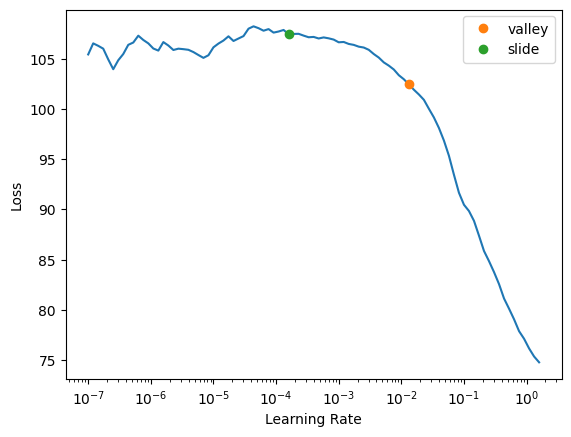

In [346]:
learn.lr_find(suggest_funcs=[valley, slide])

In [386]:
learn.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,mae,time
0,139.099487,127.762749,10.844954,00:01
1,134.104233,115.889580,10.295599,00:01
2,110.677536,82.388023,8.478065,00:01
3,73.643738,46.251007,5.996408,00:01
4,44.105919,26.103485,3.919623,00:01
5,27.657864,15.892542,2.546313,00:01
6,20.718620,11.449627,1.809597,00:01
7,18.172113,10.986734,1.751339,00:01
8,17.462255,10.899679,1.757285,00:01
9,17.199354,10.787186,1.739493,00:01


In [387]:
def mk_analysis_df(df, preds):
  return pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['SO2'],
              'Predicted': preds })

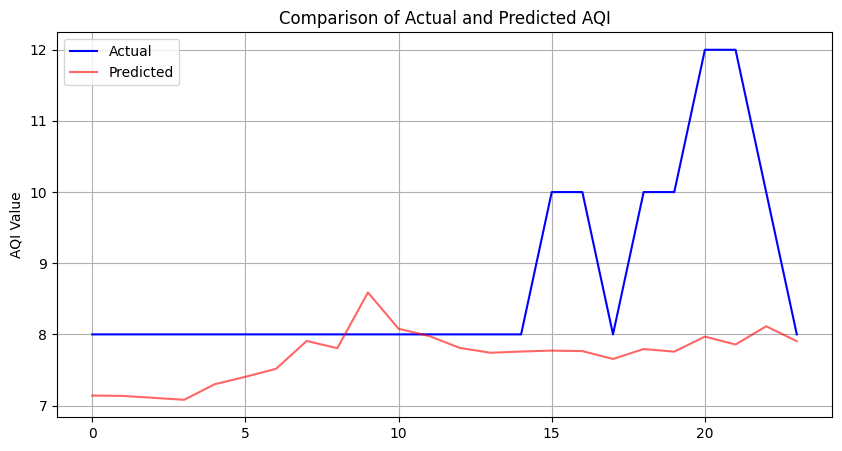

In [378]:
# # learn.recorder.plot_loss()
# learn.show_results(max_n=10)

df = merged.loc[test_idxs]
test_dl = dls.test_dl(df)
preds, targets = learn.get_preds(dl=test_dl)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(targets[:24], label='Actual', color='blue')
plt.plot(preds[:24], label='Predicted', color='red', alpha=0.6)
plt.title('Comparison of Actual and Predicted AQI')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.show()

In [388]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [389]:
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(2.2790)

In [390]:
analysis_df = mk_analysis_df(df_test, preds.flatten())

plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…

# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [391]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=100,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(1.7324)

In [392]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [393]:
preds = torch.tensor(m.predict(test_dl.xs))
mae(preds, torch.tensor(test_dl.y.values))

TensorBase(2.2322)

In [394]:
def mk_analysis_df(df, preds):
  return pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['SO2'],
              'Predicted': preds})

analysis_df = mk_analysis_df(df_test, preds)
analysis_df

,datetime,Actual,Predicted
96432,2023-01-01 00:00:00,8.0,9.131841
96433,2023-01-01 01:00:00,8.0,9.030553
96434,2023-01-01 02:00:00,8.0,9.088458
96435,2023-01-01 03:00:00,8.0,9.063873
96436,2023-01-01 04:00:00,8.0,9.060236
...,...,...,...
107587,2024-04-09 19:00:00,22.0,11.441892
107588,2024-04-09 20:00:00,16.0,11.607718
107589,2024-04-09 21:00:00,12.0,11.745655
107590,2024-04-09 22:00:00,10.0,12.300994


In [395]:
plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…